In [1]:
from __future__ import absolute_import, division, print_function
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 读取数据文件
resampled_ab_df = pd.read_csv('data_8000_abnormal.csv', encoding='cp1252')
resampled_nor_df = pd.read_csv('data_8000_normal.csv', encoding='cp1252')

print("样本数量（resampled_ab_df）：", resampled_ab_df.shape[0])
print("样本数量（resampled_nor_df）：", resampled_nor_df.shape[0])

# 数据清理和选择特征
df = pd.concat([resampled_nor_df, resampled_ab_df])
print("整合后的样本数量：", df.shape[0])

df = df.drop(columns=[' Source IP', ' Destination IP', ' Timestamp', 'Flow ID'])

if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# 将标签转换为二进制形式
def label_transfer(d):
    if d != 'BENIGN':
        return 1
    else:
        return 0

df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
df[' Label'] = df[' Label'].apply(lambda x: label_transfer(x))

# 数据标准化和组装
scaler = StandardScaler()
column_size = len(df.columns)
values = df.values[:, :column_size - 1]
scaler.fit(values)
values = scaler.transform(values)
targets = df.values[:, column_size - 1: column_size]

num_samples = len(values) // 10 * 10
grouped_data_x = np.zeros((num_samples // 10, 10, 80))
grouped_data_y = np.zeros(num_samples // 10)

for i in range(0, num_samples, 10):
    locs = np.arange(i, i + 10, 1)
    token_list = values[locs]
    grouped_data_x[int(i/10)] = token_list
    grouped_data_y[int(i/10)] = targets[i][0]

# 数据拆分为训练集和测试集
permutation = torch.randperm(len(grouped_data_x))
train_indices = list(permutation[0: int(len(grouped_data_x) * 0.8)])
test_indices = list(permutation[int(len(grouped_data_x) * 0.8): len(grouped_data_x)])

train_x = grouped_data_x[train_indices]
train_y = grouped_data_y[train_indices]
test_x = grouped_data_x[test_indices]
test_y = grouped_data_y[test_indices]


# 转换为张量格式
train_X = torch.from_numpy(train_x).type(torch.FloatTensor)
test_X = torch.from_numpy(test_x).type(torch.FloatTensor)
train_Y = torch.from_numpy(train_y).type(torch.LongTensor)
test_Y = torch.from_numpy(test_y).type(torch.LongTensor)

print(len(test_X))
# 将张量转换为DataFrame并保存为CSV文件
train_X_df = pd.DataFrame(train_X.numpy().reshape(-1, 80))
train_Y_df = pd.DataFrame(train_Y.numpy().reshape(-1, 1))
test_X_df = pd.DataFrame(test_X.numpy().reshape(-1, 80))
test_Y_df = pd.DataFrame(test_Y.numpy().reshape(-1, 1))

train_X_df.to_csv('train_X.csv', index=False)
train_Y_df.to_csv('train_Y.csv', index=False)
test_X_df.to_csv('test_X.csv', index=False)
test_Y_df.to_csv('test_Y.csv', index=False)
print(len(df.columns))

样本数量（resampled_ab_df）： 8000
样本数量（resampled_nor_df）： 8000
整合后的样本数量： 16000
320
81


In [2]:
# Model structure

import math
import torch
import torch.nn as nn

class TransformerClassifier(nn.Module):

  def __init__(self, ninp, nhead, nhid, nlayers, dropout=0.5):
    super(TransformerClassifier, self).__init__()
    from torch.nn import TransformerEncoder, TransformerEncoderLayer
    self.model_type = 'Transformer'
    encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
    self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
    self.ninp = ninp
    self.dropout = nn.Dropout(0.3)
    self.convs = nn.ModuleList([nn.Conv2d(1, 100, (K, ninp)) for K in [3,4,5]])
    self.classifier = nn.Linear(ninp, 2)
    self.fc1 = nn.Linear(len([3,4,5]) * 100, 2)
    self.init_weights()
    

  def generate_square_subsequent_mask(self, sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

  def init_weights(self):
    initrange = 0.1
    self.classifier.bias.data.zero_()
    self.classifier.weight.data.uniform_(-initrange, initrange)

  def forward2(self, src):
    # Transformer Layer
    src = src * math.sqrt(self.ninp)
    x = self.transformer_encoder(src)
    # Conv Layer
    x = x.unsqueeze(1)  # (N, Ci, W, D)
    x = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]  # [(N, Co, W), ...] * len(Ks)
    # Pooling Layer
    x = [torch.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...] * len(Ks)
    x = torch.cat(x, 1)
    # Fully Connected Layer
    x = self.dropout(x)  # (N, len(Ks)*Co)
    logit = self.fc1(x)  # (N, C)
    return logit

  def forward(self, src):
    
    # Non-conv Approch
    src = src * math.sqrt(self.ninp)
    output = self.transformer_encoder(src)

    # Average Pooling Layer
    output = output.permute(0,2,1)
    output = torch.mean(output, -1)
    output = self.dropout(output)
    output = torch.relu(self.dense(output))
    output = self.dropout(output)
    output = self.classifier(output)
    return output

  def predict(self, x):

    #Apply sigmoid to output. 
    pred = torch.sigmoid(self.forward2(x))
    ans = []
    
    #Pick the class with maximum weight
    for t in pred:
      if t[0] > t[1]:
        ans.append(0)
      else:
        ans.append(1)
    return torch.tensor(ans)

In [3]:
import torch.optim

#Initialize the model        
model = TransformerClassifier(len(df.columns) - 1, 4, 1024, 3)
#Define loss criterion
criterion = nn.CrossEntropyLoss()
#Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [4]:
#Size of traning data batch

BATCH_SIZE = 512

#Number of epochs
epochs = 10
#List to store losses
losses = []
test_losses = []

for i in range(epochs):
  
  loss_total = 0
  test_lost_total = 0

  permutation = torch.randperm(train_X.size()[0])
  for j in range(0, train_X.size()[0], BATCH_SIZE):

    #Clear the previous gradients
    optimizer.zero_grad()

    #Batch the data
    indices = permutation[j: j + BATCH_SIZE]
    batch_x, batch_y = train_X[indices], train_Y[indices]

    train_y_pred = model.forward2(batch_x)
    test_y_pred = model.forward2(test_X[0:100])

    #Compute Cross entropy loss
    loss = criterion(train_y_pred, batch_y)
    loss_total += loss
    test_lost = criterion(test_y_pred, test_Y[0:100])
    test_lost_total += test_lost

    #Add loss to the list
    losses.append(loss.item())
    test_losses.append(test_lost.item())
    
    loss.backward()
    optimizer.step()

  print(str(i) + 'th of ' + str(epochs) + ' Epoch' + " | LOSS:" + str(loss_total.data) + " | T-LOSS:" + str(test_lost_total.data))


0th of 10 Epoch | LOSS:tensor(1.7035) | T-LOSS:tensor(1.6721)
1th of 10 Epoch | LOSS:tensor(1.2141) | T-LOSS:tensor(0.9166)
2th of 10 Epoch | LOSS:tensor(0.5670) | T-LOSS:tensor(0.5380)
3th of 10 Epoch | LOSS:tensor(0.3979) | T-LOSS:tensor(0.2654)
4th of 10 Epoch | LOSS:tensor(0.2956) | T-LOSS:tensor(0.1368)
5th of 10 Epoch | LOSS:tensor(0.1361) | T-LOSS:tensor(0.1468)
6th of 10 Epoch | LOSS:tensor(0.1619) | T-LOSS:tensor(0.1796)
7th of 10 Epoch | LOSS:tensor(0.1253) | T-LOSS:tensor(0.1187)
8th of 10 Epoch | LOSS:tensor(0.1339) | T-LOSS:tensor(0.0427)
9th of 10 Epoch | LOSS:tensor(0.1218) | T-LOSS:tensor(0.0368)


In [5]:
from sklearn import metrics

results = []
for i in range(0, len(test_X) - 5, 5): # 500->10
  ret = model.predict(test_X[i:i+5])
  results.append(ret)  # 将numpy数组转换为张量并添加到results列表中
if results:
    dd = torch.cat(results)
    print(dd)
else:
    print("results列表为空")

tensor([1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,

In [6]:
print(metrics.accuracy_score(dd, test_Y[0:315]))
print(metrics.recall_score(dd, test_Y[0:315], average='micro'))

0.9841269841269841
0.9841269841269841


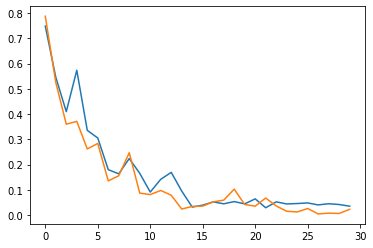

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(losses)
plt.plot(test_losses)
plt.show()

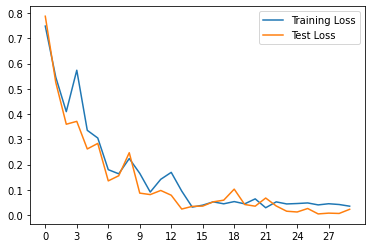

In [8]:
import matplotlib.pyplot as plt

# 假设你已经有了losses和test_losses列表

# 绘制曲线
plt.plot(losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')

# 设置横坐标刻度
num_ticks = 10  # 设置刻度数量
plt.xticks(range(0, len(losses), len(losses)//num_ticks))  # 设置刻度间距

# 添加线条名称
plt.legend(loc='upper right')

plt.show()


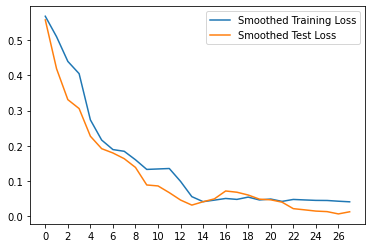

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# 假设你已经有了losses和test_losses列表

window_size = 3  # 移动平均窗口大小

# 计算移动平均
smoothed_losses = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
smoothed_test_losses = np.convolve(test_losses, np.ones(window_size)/window_size, mode='valid')

# 绘制平滑后的曲线
plt.plot(smoothed_losses, label='Smoothed Training Loss')
plt.plot(smoothed_test_losses, label='Smoothed Test Loss')

# 设置横坐标刻度
num_ticks = 10  # 设置刻度数量
plt.xticks(range(0, len(smoothed_losses), len(smoothed_losses)//num_ticks))  # 设置刻度间距

# 添加线条名称
plt.legend()

plt.show()


<AxesSubplot:>

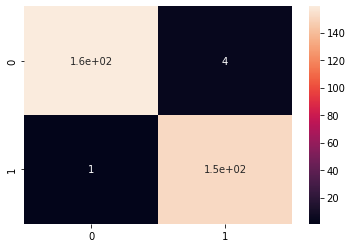

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_Y[0:315],dd)
sns.heatmap(cm, annot=True)

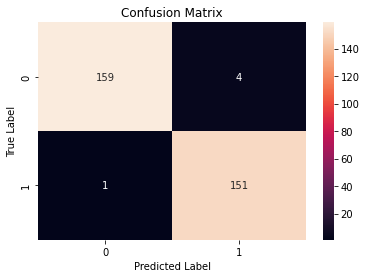

准确率： 0.9841269841269841
精确率： 0.9741935483870968
召回率： 0.993421052631579
F1分数： 0.9837133550488599


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(test_Y[0:315], dd)

# 使用Seaborn绘制热力图
sns.heatmap(cm, annot=True, fmt='d')

# 添加标题和轴标签
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 显示图像
plt.show()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 计算准确率
accuracy = accuracy_score(test_Y[0:315], dd)

# 计算精确率
precision = precision_score(test_Y[0:315], dd)

# 计算召回率
recall = recall_score(test_Y[0:315], dd)

# 计算F1分数
f1 = f1_score(test_Y[0:315], dd)

# 打印指标
print("准确率：", accuracy)
print("精确率：", precision)
print("召回率：", recall)
print("F1分数：", f1)


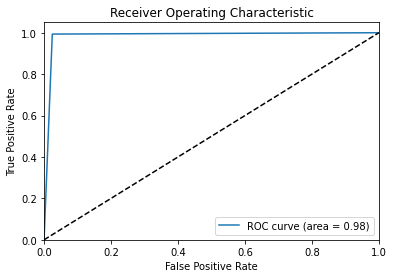

In [12]:
from sklearn.metrics import roc_curve, auc

# 计算ROC曲线的假正例率（FPR）和真正例率（TPR）
fpr, tpr, thresholds = roc_curve(test_Y[0:315], dd)

# 计算AUC（曲线下面积）
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # 绘制对角线
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


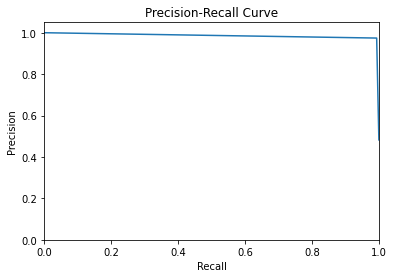

In [13]:
from sklearn.metrics import precision_recall_curve

# 计算精确率和召回率
precision, recall, thresholds = precision_recall_curve(test_Y[0:315], dd)

# 绘制精确率-召回率曲线
plt.plot(recall, precision)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
